# Initialize the accelerator

In [31]:
from finn_examples import models
print(list(filter(lambda x: "imagenet" in x, dir(models))))

['_imagenet_top5inds_io_shape_dict', 'mobilenetv1_w4a4_imagenet']


In [32]:
accel = models.mobilenetv1_w4a4_imagenet()
#some systems might require a manual platform setting:
#accel = models.mobilenetv1_w4a4_imagenet("ZCU102")

In [33]:
print("Expected input shape and datatype: %s %s" % (str(accel.ishape_normal), str(accel.idt)))
print("Expected output shape and datatype: %s %s" % (str(accel.oshape_normal), str(accel.odt)))

Expected input shape and datatype: (1, 224, 224, 3) DataType.UINT8
Expected output shape and datatype: (1, 1, 1, 5) DataType.UINT16


# Prepare loading of ImageNet validation dataset

In [34]:
import numpy as np
from PIL import Image
from dataset_loading import FileQueue, ImgQueue
import os

# 2 ways to provide the data:
# without a label file: expect images in 1000 sorted subfolders
# with a label file: expect images directly in val directory
val_dir = os.environ["IMAGENET_VAL_PATH"]
label_file = None
print(val_dir)

In [35]:
def img_resize(img, size):
    w, h = img.size
    if (w <= h and w == size) or (h <= w and h == size):
        return img
    if w < h:
        ow = size
        oh = int(size * h / w)
        return img.resize((ow, oh), Image.BILINEAR)
    else:
        oh = size
        ow = int(size * w / h)
        return img.resize((ow, oh), Image.BILINEAR)

def img_center_crop(img, size):
    crop_height, crop_width = (size, size)
    image_width, image_height = img.size
    crop_top = int(round((image_height - crop_height) / 2.))
    crop_left = int(round((image_width - crop_width) / 2.))
    return img.crop((crop_left, crop_top, crop_left + crop_width, crop_top + crop_height))

def pre_process(img_np):
    img = Image.fromarray(img_np.astype(np.uint8))
    img = img_resize(img, 256)
    img = img_center_crop(img, 224)
    img = np.array(img, dtype=np.uint8)
    return img

def setup_dataloader(val_path, label_file_path = None, batch_size=100, n_images = 50000):
    if label_file_path is None:
        val_folders = sorted(os.listdir(val_path))
        assert len(val_folders) == 1000, "Expected 1000 subfolders in ILSVRC2012 val"
        files = []
        labels = []
        for idx, folder in enumerate(val_folders):
            current_files = sorted(os.listdir(os.path.join(val_path, folder)))
            current_files = [os.path.join(folder, file) for file in current_files]
            files.extend(current_files)
            labels.extend([idx]*len(current_files))
        files = files[:n_images]
    else:
        files = ['ILSVRC2012_val_{:08d}.JPEG'.format(i) for i in range(1,n_images+1)]
        labels = np.loadtxt(label_file_path, dtype=int, usecols=1)

    file_queue = FileQueue()
    file_queue.load_epochs(list(zip(files,labels)), shuffle=False)
    img_queue = ImgQueue(maxsize=batch_size)
    img_queue.start_loaders(file_queue, num_threads=4, img_dir=val_path, transform=pre_process)
    return img_queue

# Classify a single image

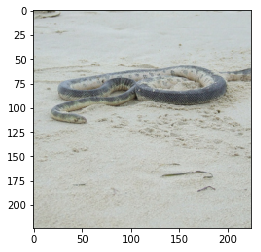

In [36]:
%matplotlib inline
from matplotlib import pyplot as plt

img_queue = setup_dataloader(val_dir, label_file, 1, 1)

test_single_x, test_single_y = img_queue.get()

plt.imshow(test_single_x)
plt.show()

In [37]:
test_single_y

65

In [38]:
accel_in = test_single_x.reshape(accel.ishape_normal)
print("Input buffer shape is %s and datatype is %s" % (str(accel_in.shape), str(accel_in.dtype)))

Input buffer shape is (1, 224, 224, 3) and datatype is uint8


In [39]:
accel_out = accel.execute(accel_in)

In [40]:
print("Top-5 classes predicted by the accelerator: " + str(accel_out))

Top-5 classes predicted by the accelerator: [[[[50. 65. 54. 34. 49.]]]]


In [41]:
%%timeit
accel_out = accel.execute(accel_in)

100 loops, best of 3: 11.6 ms per loop


# Validate accuracy on entire ImageNet validation set

In [42]:
batch_size = 100
accel.batch_size = batch_size
print("Accelerator buffer shapes are %s for input, %s for output" % (str(accel.ishape_packed), str(accel.oshape_packed)) )

Accelerator buffer shapes are (100, 224, 224, 1, 3) for input, (100, 1, 1, 1, 10) for output


In [43]:
img_queue = setup_dataloader(val_dir, label_file, batch_size)

ok = 0
nok = 0
i = 0
while not img_queue.last_batch:
    imgs, lbls = img_queue.get_batch(batch_size, timeout=None)
    imgs = np.array(imgs)
    exp = np.array(lbls)
    
    ibuf_normal = imgs.reshape(accel.ishape_normal)
    obuf_normal = accel.execute(ibuf_normal)
    obuf_normal = obuf_normal.reshape(batch_size, -1)[:,0]
    ret = np.bincount(obuf_normal.flatten() == exp.flatten())
    nok += ret[0]
    ok += ret[1]
    i += 1
    print("batch %d : total OK %d NOK %d" % (i, ok, nok))

batch 1 : total OK 75 NOK 25
batch 2 : total OK 143 NOK 57
batch 3 : total OK 200 NOK 100
batch 4 : total OK 266 NOK 134
batch 5 : total OK 347 NOK 153
batch 6 : total OK 419 NOK 181
batch 7 : total OK 495 NOK 205
batch 8 : total OK 569 NOK 231
batch 9 : total OK 641 NOK 259
batch 10 : total OK 707 NOK 293
batch 11 : total OK 785 NOK 315
batch 12 : total OK 862 NOK 338
batch 13 : total OK 939 NOK 361
batch 14 : total OK 1006 NOK 394
batch 15 : total OK 1076 NOK 424
batch 16 : total OK 1140 NOK 460
batch 17 : total OK 1212 NOK 488
batch 18 : total OK 1281 NOK 519
batch 19 : total OK 1352 NOK 548
batch 20 : total OK 1418 NOK 582
batch 21 : total OK 1497 NOK 603
batch 22 : total OK 1564 NOK 636
batch 23 : total OK 1634 NOK 666
batch 24 : total OK 1709 NOK 691
batch 25 : total OK 1785 NOK 715
batch 26 : total OK 1855 NOK 745
batch 27 : total OK 1927 NOK 773
batch 28 : total OK 1998 NOK 802
batch 29 : total OK 2073 NOK 827
batch 30 : total OK 2137 NOK 863
batch 31 : total OK 2209 NOK 891
ba

batch 237 : total OK 16768 NOK 6932
batch 238 : total OK 16840 NOK 6960
batch 239 : total OK 16902 NOK 6998
batch 240 : total OK 16965 NOK 7035
batch 241 : total OK 17035 NOK 7065
batch 242 : total OK 17103 NOK 7097
batch 243 : total OK 17177 NOK 7123
batch 244 : total OK 17246 NOK 7154
batch 245 : total OK 17312 NOK 7188
batch 246 : total OK 17385 NOK 7215
batch 247 : total OK 17454 NOK 7246
batch 248 : total OK 17527 NOK 7273
batch 249 : total OK 17598 NOK 7302
batch 250 : total OK 17670 NOK 7330
batch 251 : total OK 17739 NOK 7361
batch 252 : total OK 17813 NOK 7387
batch 253 : total OK 17883 NOK 7417
batch 254 : total OK 17954 NOK 7446
batch 255 : total OK 18026 NOK 7474
batch 256 : total OK 18098 NOK 7502
batch 257 : total OK 18177 NOK 7523
batch 258 : total OK 18244 NOK 7556
batch 259 : total OK 18318 NOK 7582
batch 260 : total OK 18386 NOK 7614
batch 261 : total OK 18457 NOK 7643
batch 262 : total OK 18526 NOK 7674
batch 263 : total OK 18590 NOK 7710
batch 264 : total OK 18661 N

batch 462 : total OK 32530 NOK 13670
batch 463 : total OK 32605 NOK 13695
batch 464 : total OK 32673 NOK 13727
batch 465 : total OK 32741 NOK 13759
batch 466 : total OK 32815 NOK 13785
batch 467 : total OK 32889 NOK 13811
batch 468 : total OK 32961 NOK 13839
batch 469 : total OK 33031 NOK 13869
batch 470 : total OK 33107 NOK 13893
batch 471 : total OK 33180 NOK 13920
batch 472 : total OK 33249 NOK 13951
batch 473 : total OK 33320 NOK 13980
batch 474 : total OK 33387 NOK 14013
batch 475 : total OK 33456 NOK 14044
batch 476 : total OK 33525 NOK 14075
batch 477 : total OK 33589 NOK 14111
batch 478 : total OK 33663 NOK 14137
batch 479 : total OK 33736 NOK 14164
batch 480 : total OK 33810 NOK 14190
batch 481 : total OK 33870 NOK 14230
batch 482 : total OK 33941 NOK 14259
batch 483 : total OK 34015 NOK 14285
batch 484 : total OK 34087 NOK 14313
batch 485 : total OK 34162 NOK 14338
batch 486 : total OK 34237 NOK 14363
batch 487 : total OK 34303 NOK 14397
batch 488 : total OK 34371 NOK 14429
b

In [44]:
total = 50000
acc = 100.0 * ok / (total)
print("Final top-1 accuracy: {}%".format(acc))

Final top-1 accuracy: 70.406%


## More benchmarking

In [45]:
accel.throughput_test()

{'DRAM_in_bandwidth[Mb/s]': 36.9023558742973,
 'DRAM_out_bandwidth[Mb/s]': 0.002451527680849895,
 'batch_size': 100,
 'copy_input_data_to_device[ms]': 0.012581110000610352,
 'copy_output_data_from_device[ms]': 0.00011181831359863281,
 'fclk[mhz]': 99.999,
 'fold_input[ms]': 5.602836608886719e-05,
 'pack_input[ms]': 7.963180541992188e-05,
 'runtime[ms]': 407.9089164733887,
 'throughput[images/s]': 245.15276808498948,
 'unfold_output[ms]': 4.315376281738281e-05,
 'unpack_output[ms]': 0.06317782402038574}